<a href="https://colab.research.google.com/github/kckohkoh2/fantastic-disco/blob/master/day0112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

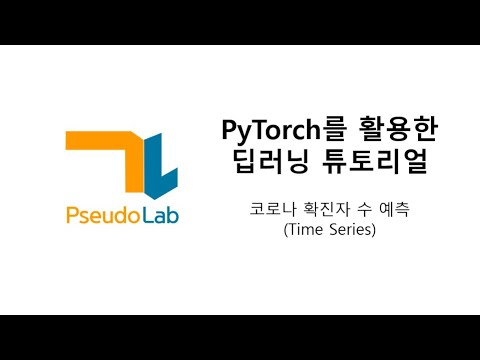

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo(id="X6U4eBzOiNM", width=560, height=315)

In [2]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
!unzip -q COVIDTimeSeries.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 36 (delta 12), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (36/36), done.
Downloading...
From: https://drive.google.com/uc?id=1B36Djko-f0LtVxSaBEVYosLTTsu0qtsh
To: /content/COVIDTimeSeries.zip
100% 3.18M/3.18M [00:00<00:00, 249MB/s]
COVIDTimeSeries.zip download complete!


In [5]:
#대한민국 데이터만 추출 후 일자별 확진자 수로 변환
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed[confirmed['Country/Region']=='Korea, South']
korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

#지도학습용 데이터로 변환
seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

#학습용, 검증용, 시험용으로 분리
train_size = int(327 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

#MinMax 스케일링
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

#Tensor 형태로 변환
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [6]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([261, 5, 1]) torch.Size([33, 5, 1]) torch.Size([33, 5, 1])
torch.Size([261, 1]) torch.Size([33, 1]) torch.Size([33, 1])


In [10]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [11]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [12]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.08467356753589093 val loss: 0.047220394015312195
Epoch 10 train loss: 0.03268902561309751 val loss: 0.03414301946759224
Epoch 20 train loss: 0.03255926682774363 val loss: 0.03243740275502205
Epoch 30 train loss: 0.03268276200044572 val loss: 0.03306415677070618
Epoch 40 train loss: 0.03259286329139495 val loss: 0.032514143735170364
Epoch 50 train loss: 0.032316437548640185 val loss: 0.03300009295344353
Epoch 60 train loss: 0.03259847946625588 val loss: 0.032665640115737915
Epoch 70 train loss: 0.03220883483991341 val loss: 0.03289766609668732
Epoch 80 train loss: 0.03264666250478691 val loss: 0.03258885443210602
Epoch 90 train loss: 0.032349442671520554 val loss: 0.03221791982650757


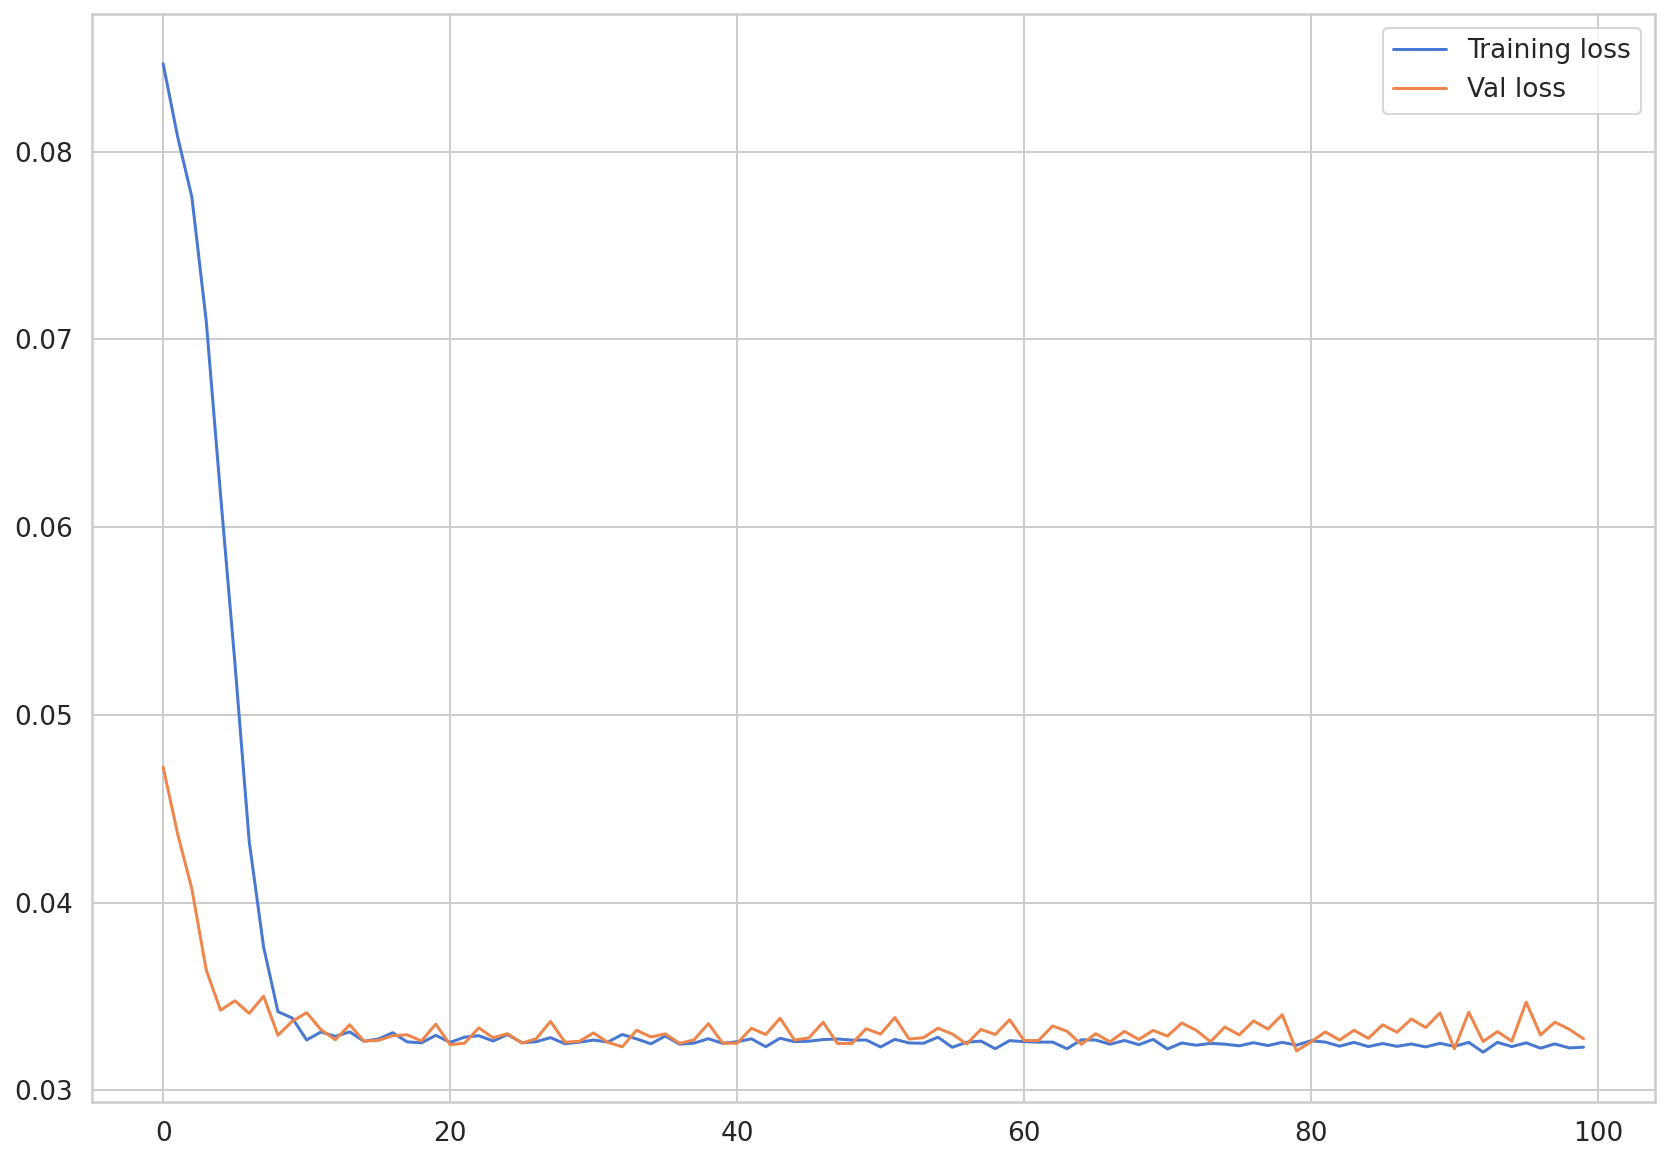

In [13]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()